In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm


In [2]:
path_to_dataset = "drive//MyDrive//M202A//nyu_depth_v2_labeled.mat"

def extract_files(config):
  path = config["path"]
  f = h5py.File(path_to_dataset)
  length = len(f["images"])
  indices = np.random.randint(0,length,size=length//3)
  batch_size = length//3
  color = np.zeros((batch_size,480,640,3))
  rawdepth = np.zeros((batch_size,480,640))
  truedepth = np.zeros_like(rawdepth)
  for i in tqdm(range(0,len(indices))):
    j = indices[i]
    # read 0-th image. original format is [3 x 640 x 480], uint8
    img = f['images'][j].astype(np.uint8)
    img = img.transpose(2,1,0)
    color[i,...] = img
    rawD = f['rawDepths'][j]
    rawdepth[i,...] = rawD.T.astype(np.float32)
    depth_from_disk = f["depths"][j].astype(np.float32)
    truedepth[i,...] = depth_from_disk.T
  config["color"] = color[:,50:-50,50:-50]
  config["depth"] = truedepth[:,50:-50,50:-50]
  config["rawDepth"] = rawdepth[:,50:-50,50:-50]
config={"path":path_to_dataset}
extract_files(config)

100%|██████████| 483/483 [01:11<00:00,  6.80it/s]


380


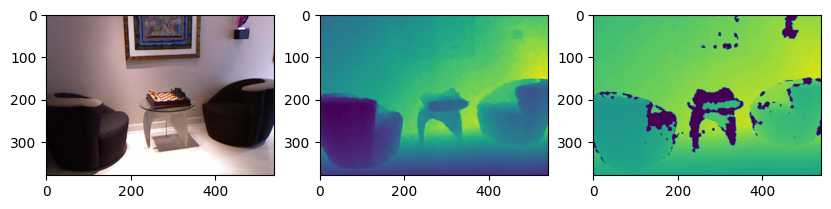

In [3]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0].astype(np.uint8))

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])


print(len(rawdepth[0]))

In [4]:
length = len(color)
error = []

denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
  denoised_depth_images[i,...] = cv2.bilateralFilter(rawdepth[i].astype(np.float32),5,150,150)
  validity_mask = rawdepth[i]>0
  error.append((depth[i][validity_mask]-denoised_depth_images[i][validity_mask]))



100%|██████████| 483/483 [00:04<00:00, 111.69it/s]


Average MAE is  44.345258818359675
Average root mean squared error is  196.89087954412713


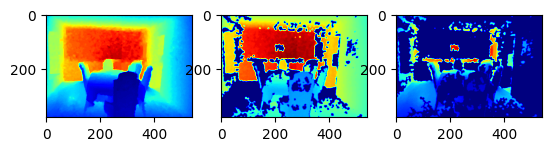

In [7]:
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average MAE is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3)
axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')

(-0.5, 539.5, 379.5, -0.5)

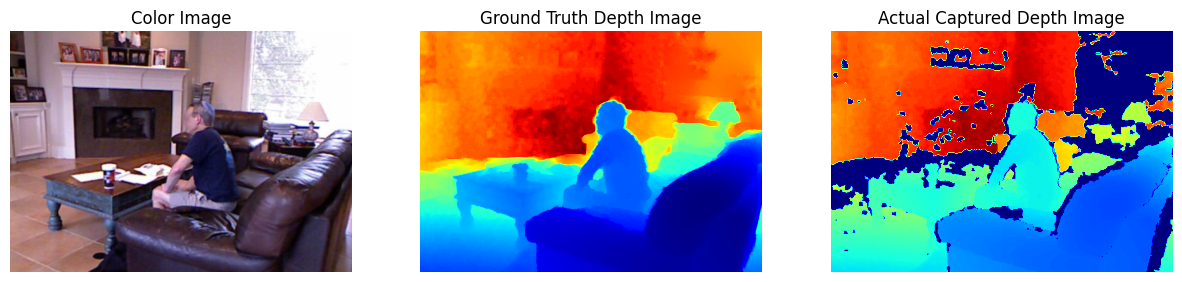

In [18]:
random_indice = np.random.randint(low=0,high = len(mae))
fig,axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(color[random_indice].astype(np.uint8))
axs[0].set_title("Color Image")
axs[0].axis("off")
axs[1].imshow(depth[random_indice],cmap="jet")
axs[1].axis("off")
axs[1].set_title("Ground Truth Depth Image")
axs[2].imshow(rawdepth[random_indice],cmap="jet")
axs[2].set_title("Actual Captured Depth Image")
axs[2].axis("off")